# Using the DeCam images to subtract DP1 images

**Description:** This notebook demonstrates how to perform image subtraction on LSST data using DECam templates

**author:** Yize Dong

**email:** yize.dong@cfa.harvard.edu



## load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from lsst_decam_subtraction.subtraction import lsst_decam_data_load, perform_image_subtraction
from lsst_decam_subtraction.lsst_utils import query_lsst_visits, astropy_world_to_pixel, forced_phot
from lsst.daf.butler import Butler
from astropy.visualization import PercentileInterval, ImageNormalize

In [2]:
butler = Butler("dp1", collections="LSSTComCam/DP1")

## query images
Find images that are within the timespan and contain the source we are interested

In [3]:
ra = 58.335054 
dec = -48.750303
band = 'g'
time1 = '2024-12-01'
time2 = '2024-12-10'
data_query = query_lsst_visits(butler=butler, ra=ra, dec=dec, band=band, time1=time1, time2=time2)

In [4]:
data_query[0]

DatasetRef(DatasetType('visit_image', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTComCam', detector: 2, visit: 2024120800422, band: 'g', day_obs: 20241208, physical_filter: 'g_01'}, run='LSSTComCam/runs/DRP/DP1/DM-51335', id=7fe8d556-dab5-4876-ae3c-e8575e59426e)

In [5]:
visit_image = butler.get(data_query[0])

## prepare for the difference imaging step
This will download the templates from the DES-DR2, calibrate the WCS of both the science and the template images, and align the template image with the science image.

INFO: Query finished. [astroquery.utils.tap.core]


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

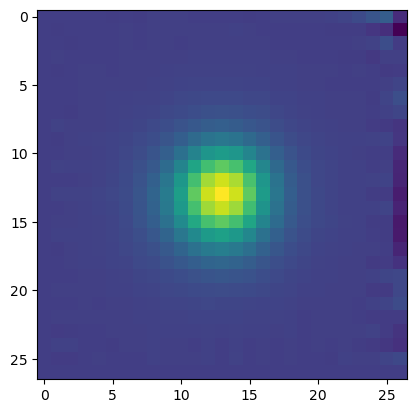

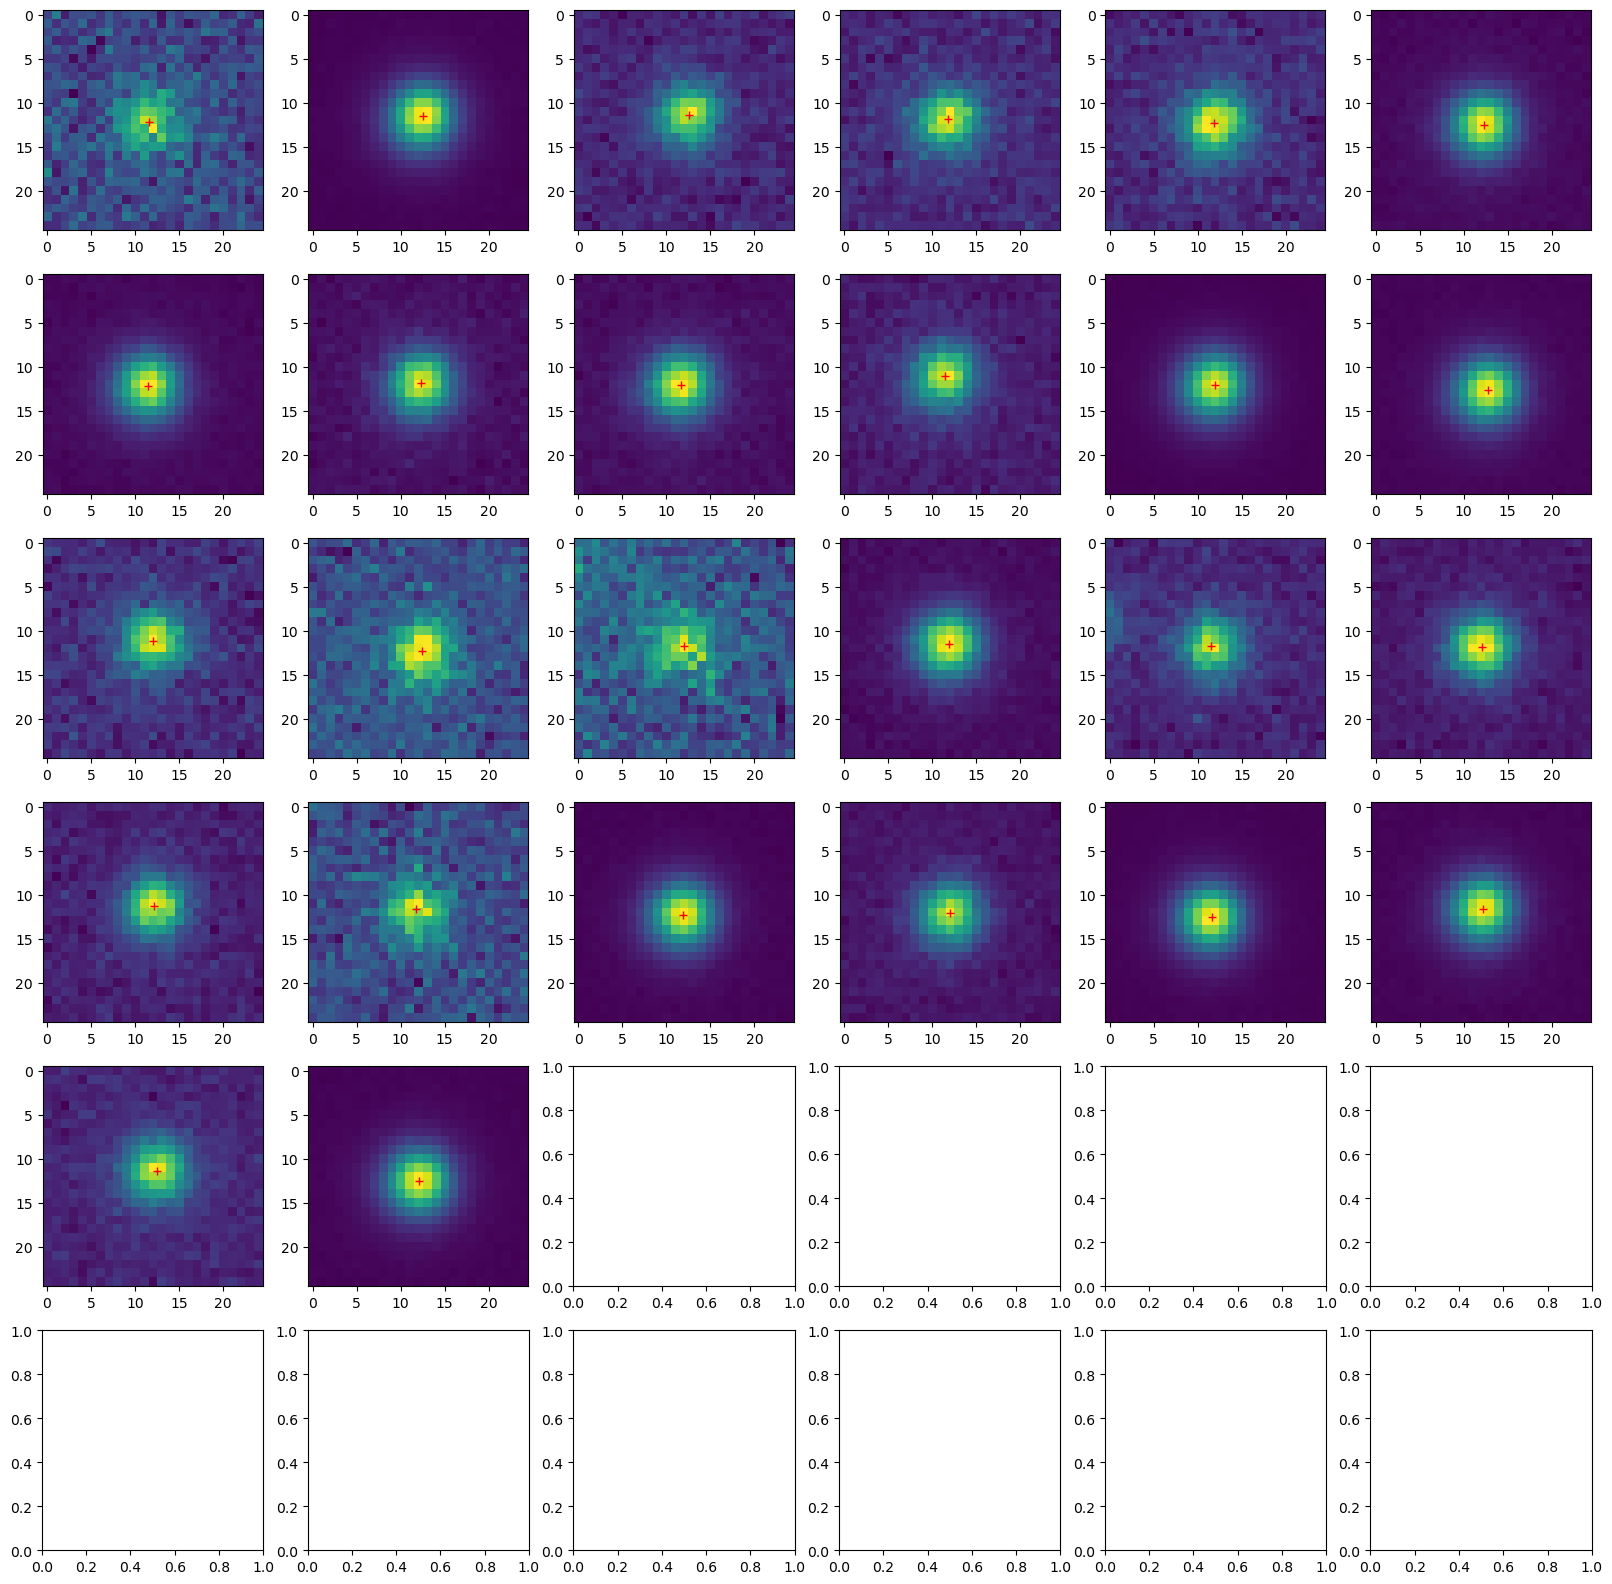

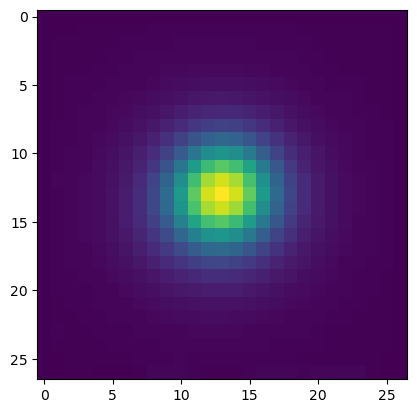

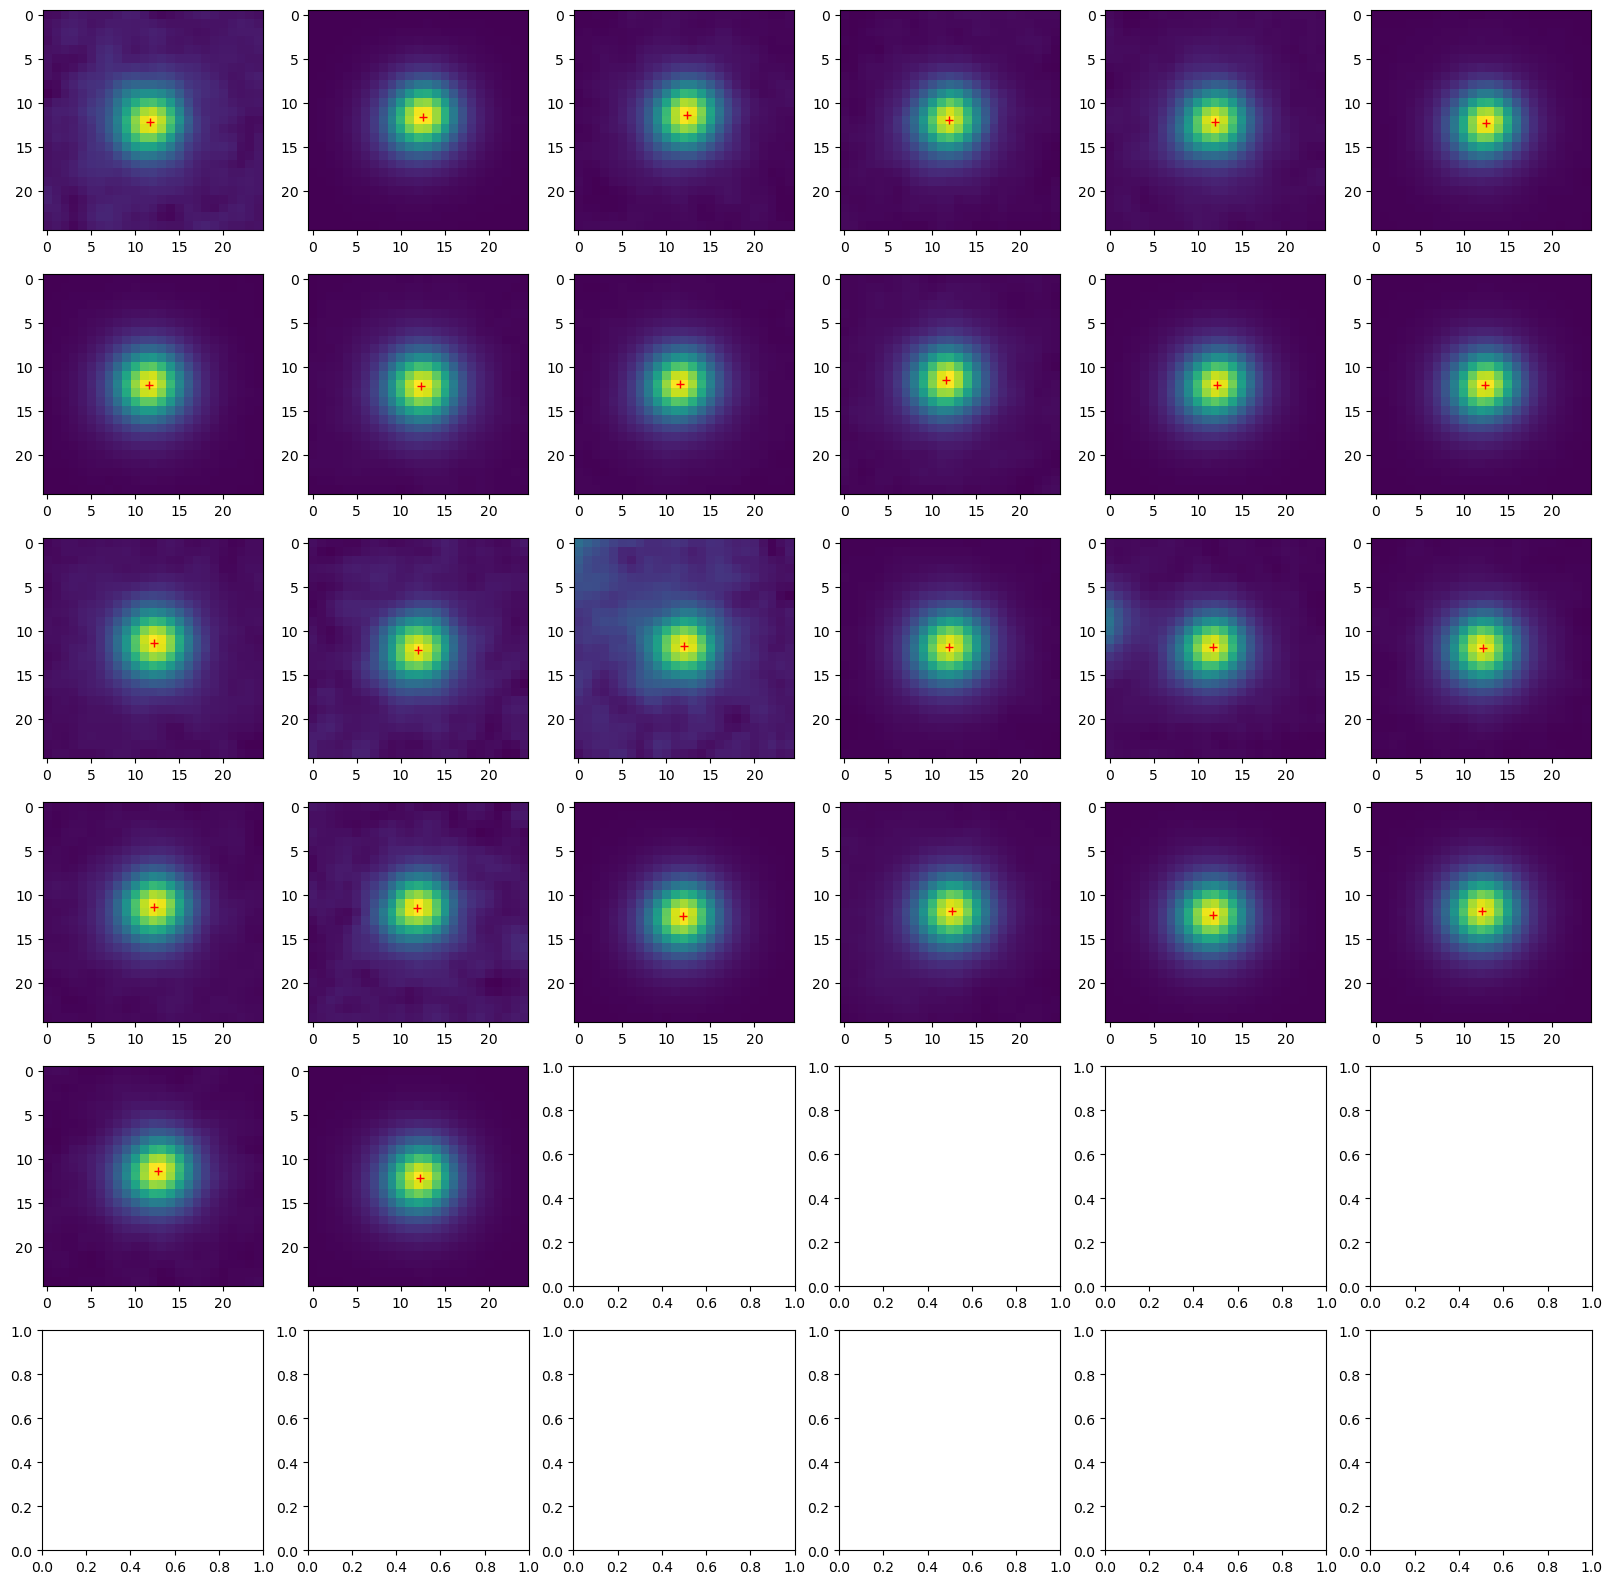

In [6]:
scidata, refdata, sci_psf, ref_psf, ref_global_bkg = lsst_decam_data_load(visit_image, ra = ra, dec = dec, download_DES_temp=True, show=True, 
                                                          cutout=True, cutout_size=2000, save_intermediate=False, save_original_temp=True)

## image subtraction
This will perform the image subtration and return the aligned template, final difference image, and the PSF for the photometry stage. This can take a few mins.

In [7]:
refdata_aligned, normalized_difference, diff_psf = perform_image_subtraction(scidata, refdata, sci_psf, ref_psf, ref_global_bkg,
                          save_intermediate=False, show=False, sigma_cut=5, max_iterations=3)#, gain_ratio=3.8

(-18.818559424624482, 381.1814405753755)

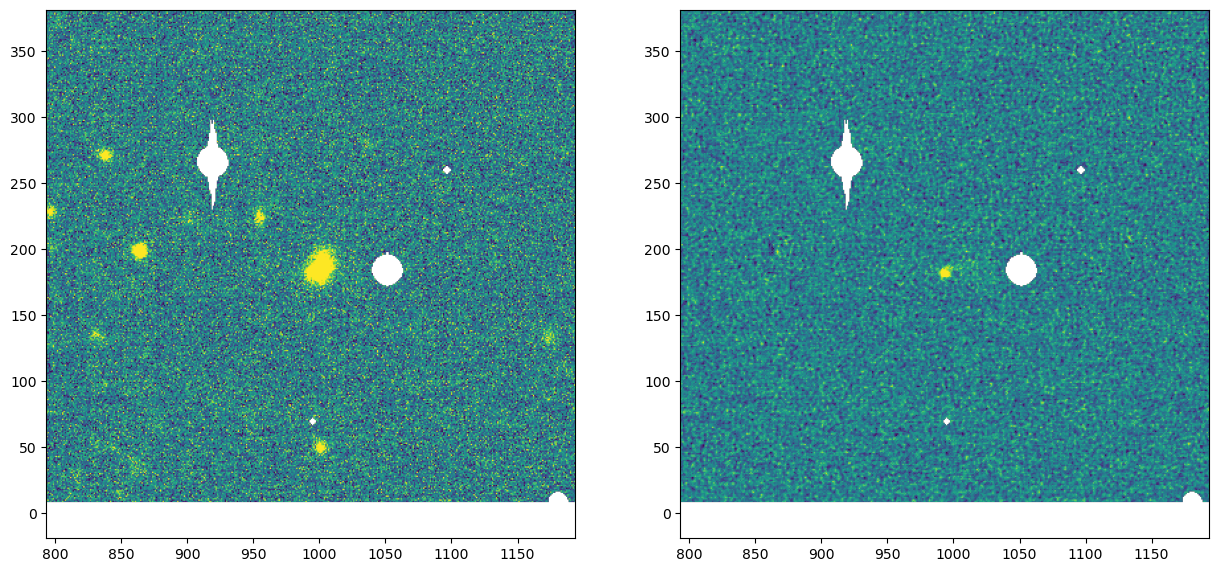

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
norm = ImageNormalize(scidata, PercentileInterval(98))
ax1.imshow(scidata, norm=norm)
_x, _y = astropy_world_to_pixel(ra, dec, scidata.wcs)
#ax1.plot(x, y, marker='o', mec='r', mfc='none', ls='none')
ax1.set_xlim(_x-200, _x+200)
ax1.set_ylim(_y-200, _y+200)


ax2.imshow(normalized_difference, norm=norm)
ax2.set_xlim(_x-200, _x+200)
ax2.set_ylim(_y-200, _y+200)

## Do photometry on the difference image at the provided position

In [9]:
flux_njy, flux_err, mag, mag_err, upper_limit = forced_phot(ra, dec, normalized_difference, scidata.wcs, diff_psf)

In [22]:
flux_njy, flux_err, mag, mag_err, upper_limit

(np.float64(4168.4671779077535),
 np.float64(116.89539715223155),
 np.float64(22.350124656643864),
 np.float64(0.03044705870071427),
 np.float64(24.48314708440889))

In [10]:
flux_njy, flux_err, mag, mag_err, upper_limit

(np.float64(4238.199085014418),
 np.float64(113.46564482754664),
 np.float64(22.332112238813178),
 np.float64(0.029067477981647303),
 np.float64(24.515479647495425))